---
# Exploratory Data Analysis

## Importaciones necesarias

In [31]:
# Gestión y extracción de archivos
import os
import pandas as pd
import numpy as np
import random
import zipfile
import shutil
from tensorflow.keras.utils import image_dataset_from_directory

# Visualización de imágenes
from skimage import io
import matplotlib.pyplot as plt
import seaborn as sns

# Red neuronal
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.densenet import DenseNet121 
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.models import Model 
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Dense, Flatten, Conv2D, MaxPool2D, PReLU
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D
from tensorflow.keras.metrics import Recall
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.initializers import GlorotUniform

# Ajuste de hiperparámetros
import keras_tuner as kt
import visualkeras

# Evaluación de resultados
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report

In [32]:
%matplotlib inline


---
## 1. Selección de artistas y preprocesamiento
El dataset utilizado para el proyecto fue descargado de [Kaggle](https://www.kaggle.com/ikarus777/best-artworks-of-all-time) y contiene pinturas de 50 pintores internacionales, con un total de 8.446 cuadros.  
Las obras presentes difieren mucho entre sí tanto en tamaño como en color y estilo.

In [33]:
artists = pd.read_csv('dataset/artists.csv')

[]

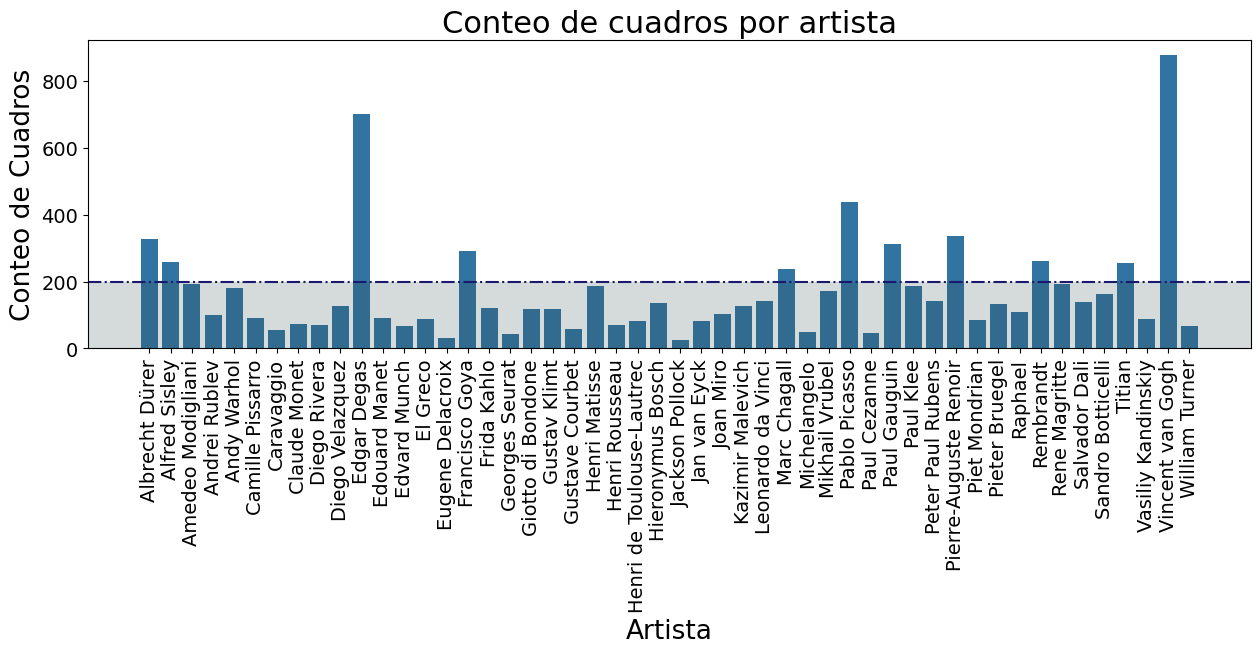

In [34]:
artists = artists.sort_values(by=['name'], ascending=True)

figsize=(15, 4)

ticksize = 14
titlesize = ticksize + 8
labelsize = ticksize + 5

xlabel = "Artista"
ylabel = "Conteo de Cuadros"

title = "Conteo de cuadros por artista"


params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)

col1 = "name"
col2 = "paintings"

sns.barplot(x=col1, y=col2, data=artists)
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xticks(rotation=90)
plt.axhline(y=200, color='midnightblue', linestyle='-.')
plt.axhspan(0, 200, facecolor ='darkslategrey', alpha = 0.2)
plt.plot()

Como se puede observar en la figura anterior, la mayoría de los artistas tiene menos de 200 cuadros, y solo dos de ellos (Degas y Van Gogh) tienen más de 600.  
Si se incluyeran todos los pintores, el dataset resultante estaría excesivamente desbalanceado y nos generaría limitaciones a nivel computacional.  
Por esta razón, se decidió considerar únicamente a los artistas que tienen más de **200** pinturas; de este modo, se conservan **10 artistas**, con un total de aproximadamente **4.300 imágenes**.

In [35]:
# Ordenar el dataframe de artistas por número de cuadros
artists = artists.sort_values(by=['paintings'], ascending=False)

# Crear un nuevo dataframe artists_top con los autores que tienen más de 200 cuadros
artists_top = artists[artists['paintings'] >= 200].reset_index() 
artists_top = artists_top[['name', 'paintings']]

In [36]:
artists_top

name  paintings
0        Vincent van Gogh        877
1             Edgar Degas        702
2           Pablo Picasso        439
3   Pierre-Auguste Renoir        336
4          Albrecht Dürer        328
5            Paul Gauguin        311
6          Francisco Goya        291
7               Rembrandt        262
8           Alfred Sisley        259
9                  Titian        255
10           Marc Chagall        239

In [37]:
# Nombres de los artistas (reemplazando espacios por guiones bajos)
artist_names = [p.replace(' ', '_') for p in artists_top.name]

# Número de clases (artistas distintos)
num_classes = len(artist_names)

In [38]:
# Verificación de si existen carpetas con el nombre mal codificado para el artista "Albrecht Dürer"
#( len(sorted(os.listdir('dataset/images/images/Albrecht_Dürer'))) ==
# len(sorted(os.listdir('dataset/images/images/Albrecht_Du╠êrer'))) )

Dado que dentro del dataset hay una carpeta con un nombre incorrecto, '*Albrecht DuΓòá├¬rer*' en lugar de '*Albrecht Durer*', en la función que sigue se ha corregido dicho error.  
El dataset original no estaba dividido en entrenamiento y prueba, así que vamos a realizar nosotros la división, manteniendo un porcentaje del **80-20**.

In [39]:
def split_train_test(path_images, painters, train_path, test_path, frac = 0.2):
    """
    A partir de la carpeta que contiene todas las imágenes, se generan dos subcarpetas:
    una para entrenamiento y otra para prueba (test).

    :param str path_images: ruta de la carpeta con todas las imágenes
    :param list painters: lista de cadenas con los nombres de los pintores seleccionados
    :param str train_path: ruta de destino para el conjunto de entrenamiento
    :param str test_path: ruta de destino para el conjunto de prueba
    :param float frac: fracción de imágenes que se moverán al conjunto de prueba;
                       el resto (1 - frac) se moverán al conjunto de entrenamiento
    """

    # Si no existe la carpeta de test, la crea
    if not os.path.isdir(test_path):
        os.makedirs(test_path)

    

    # Lista de carpetas dentro del directorio de imágenes
    folders = sorted(os.listdir(path_images))
    print('\n\n======= Creando carpetas de entrenamiento y prueba =======')
    for f in folders:

        # Solo se consideran los pintores seleccionados
        if f in painters:

            # Crear carpeta para el conjunto de prueba (si no existe)
            if not os.path.isdir(test_path + f):
                os.makedirs(test_path + f)

            painter_dir = path_images + f + '/'
            painter_file = os.listdir(path_images + f)
            
            # Número de cuadros que irán al conjunto de prueba
            num_sample = round(len(painter_file) * frac)
            # Seleccionar aleatoriamente imágenes para el conjunto de prueba
            paintings = random.sample(painter_file, num_sample)

            # Mover imágenes al conjunto de prueba
            for p in paintings:
                shutil.move(painter_dir + p, test_path + f + '/' + p)

            # Crear carpeta para el conjunto de entrenamiento (si no existe)
            if not os.path.isdir(train_path + f):
                os.makedirs(train_path + f)

            # Recalcular archivos restantes en la carpeta original
            painter_file = os.listdir(path_images + f)
            # Mover imágenes restantes al conjunto de entrenamiento
            for p in painter_file:
                shutil.move(painter_dir + p, train_path + f + '/' + p)

    print('\nFinalizada la creación de carpetas.')

In [40]:
split_train_test("dataset/images/images/", artist_names, train_path = 'data/Train/',
                 test_path = 'data/Test/', frac = 0.2)



======= Creando carpetas de entrenamiento y prueba =======

Finalizada la creación de carpetas.


In [41]:
print('Número de pintores en el conjunto de entrenamiento: ',
      str(len(sorted(os.listdir('data/Train/')))))
print('\nNúmero de pintores en el conjunto de prueba: ',
      str(len(sorted(os.listdir('data/Test/')))))

Número de pintores en el conjunto de entrenamiento:  10

Número de pintores en el conjunto de prueba:  10


In [42]:
sample_train = [p-round(p*0.2) for p in
                artists[artists['paintings'] >= 200].reset_index().paintings]
sample_test = [round(p*0.2) for p in
               artists[artists['paintings'] >= 200].reset_index().paintings]

El dataframe creado anteriormente, `artists_top`, ha sido actualizado con la incorporación de tres columnas:

- *train*: el número de cuadros del artista correspondiente en el conjunto de entrenamiento;
- *test*: el número de cuadros del artista correspondiente en el conjunto de prueba;
- *class_weight*: el peso que tiene cada artista en el dataset, en función del número de cuadros.

Esta última variable se calcula como:

$$
\frac{\text{número total de cuadros en el entrenamiento}}{\text{número de artistas} \times \text{número de cuadros por artista}}
$$

In [43]:
artists_top = artists_top.rename(columns={"paintings": "tot_paintings"})
artists_top['train'] = sample_train
artists_top['test'] = sample_test
# Creazione variabile di peso
artists_top['class_weight'] = artists_top.train.sum() / (artists_top.shape[0] *
                                                         artists_top.train)

In [44]:
artists_top

name  tot_paintings  train  test  class_weight
0        Vincent van Gogh            877    702   175      0.445480
1             Edgar Degas            702    562   140      0.556454
2           Pablo Picasso            439    351    88      0.890961
3   Pierre-Auguste Renoir            336    269    67      1.162555
4          Albrecht Dürer            328    262    66      1.193616
5            Paul Gauguin            311    249    62      1.255933
6          Francisco Goya            291    233    58      1.342177
7               Rembrandt            262    210    52      1.489177
8           Alfred Sisley            259    207    52      1.510760
9                  Titian            255    204    51      1.532977
10           Marc Chagall            239    191    48      1.637316

In [45]:
# Creación del diccionario con pesos
CLASS_WEIGHTS = artists_top['class_weight'].to_dict()

In [46]:
CLASS_WEIGHTS

{0: 0.44548044548044546,
 1: 0.556454221934649,
 2: 0.8909608909608909,
 3: 1.1625549172017573,
 4: 1.193615544760583,
 5: 1.2559328221978825,
 6: 1.3421771361685524,
 7: 1.4891774891774892,
 8: 1.5107597716293368,
 9: 1.5329768270944741,
 10: 1.6373155640171346}

Hemos decidido mantener desbalanceadas las 11 clases del dataset, pero especificaremos durante el *ajuste* de los modelos el parámetro `class_weights`, que tiene en cuenta el peso de cada clase dentro del conjunto de datos.

In [47]:
# Lista con los nombres de los pintores seleccionados en orden alfabético
labels = list(artists_top.name.sort_values())

---
## 2. Carga de datos


En esta sección se define una función para cargar las imágenes del dataset de forma estructurada. Durante la carga, las imágenes se redimensionan a un tamaño uniforme de **224×224 píxeles**, lo que facilita su procesamiento posterior por las redes neuronales.  
Los datos se agrupan en *batches* de tamaño **64**, y se reserva un **10%** del conjunto de entrenamiento para validación mediante el parámetro `validation_split`.


In [48]:
def import_data(train_path, test_path, img_size=(224, 224), batch_size=64,
                val_split=0.1):
    """
    Importa las imágenes para los conjuntos de entrenamiento, validación y prueba
    utilizando la función image_dataset_from_directory de Keras.

    :param tuple img_size: tamaño al que se redimensionarán las imágenes
    :param int batch_size: tamaño de los lotes (batches) para los conjuntos
    :param float val_split: proporción del conjunto de entrenamiento reservada para validación
    :param str train_path: ruta de la carpeta que contiene las imágenes de entrenamiento
    :param str test_path: ruta de la carpeta que contiene las imágenes de prueba
    """
    
    print('=========== CONJUNTO DE TRAINING ===========')
    train_set = keras.preprocessing.image_dataset_from_directory(
        train_path,
        image_size=img_size,
        color_mode='rgb',
        batch_size=batch_size,
        label_mode='categorical',
        shuffle=True,
        validation_split=val_split,
        subset='training',
        seed=1)

    print('\n\n=========== CONJUNTO DE VALIDACIÓN ===========')
    val_set = keras.preprocessing.image_dataset_from_directory(
        train_path,
        image_size=img_size,
        color_mode='rgb',
        batch_size=batch_size,
        label_mode='categorical',
        shuffle=True,
        validation_split=val_split,
        subset='validation',
        seed=1)

    print('\n\n=========== CONJUNTO DE TEST ===========')
    test_set = keras.preprocessing.image_dataset_from_directory(
        test_path,
        image_size=img_size,
        color_mode='rgb',
        batch_size=batch_size,
        label_mode='categorical',
        shuffle=False,
        seed=1)

    return train_set, val_set, test_set

In [49]:
train_set, val_set, test_set = import_data(train_path = "data/" + "Train",
                                           test_path = "data/" + "Test")

=========== CONJUNTO DE TRAINING ===========
Found 3178 files belonging to 10 classes.
Using 2861 files for training.


=========== CONJUNTO DE VALIDACIÓN ===========
Found 3178 files belonging to 10 classes.
Using 317 files for validation.


=========== CONJUNTO DE TEST ===========
Found 793 files belonging to 10 classes.


In [50]:
# Inspección de las dimensiones de los elementos del dataset
train_set.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))

In [51]:
# Extracción de las etiquetas  del conjunto de test
y_test = np.concatenate([y for x, y in test_set], axis=0)
y_test = [np.argmax(l) for l in y_test]

In [52]:
INPUT_SHAPE = (224,224,3)
NUM_CLASSES = 11

---
### 2.1. Visualización del contenido del dataset

A continuación se muestra una visualización de 9 pinturas seleccionadas aleatoriamente del conjunto de entrenamiento.



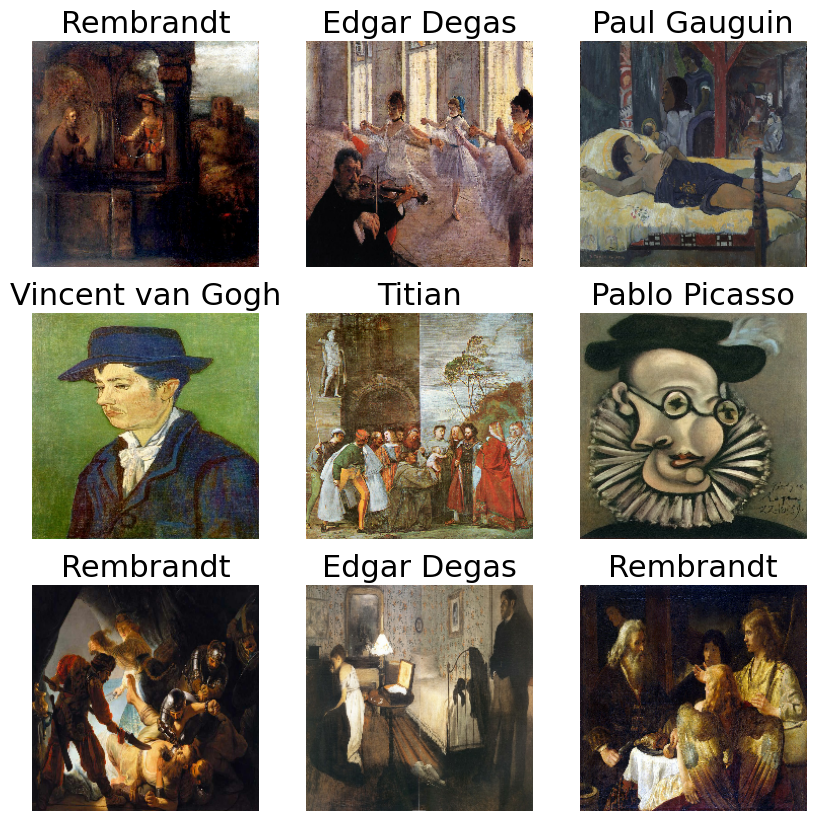

In [53]:
 # Visualización de 9 imágenes aleatorias
class_names = train_set.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1):  # Solo 1 batch para mostrar 9 imágenes
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        # Obtener índice del pintor
        author_index = tf.argmax(labels[i]).numpy()
        author = class_names[author_index].split('_')

        # Reconstruir nombre del pintor
        title = ' '.join(author)
        plt.title(title)
        plt.axis("off")

---
### 2.2. Visualización del histograma en escala de grises

Cada imagen se presenta junto a su histograma de intensidad en escala de grises y su distribución acumulada (CDF), lo que permite analizar la distribución de niveles de brillo y contraste en las obras de diferentes pintores.

Como parte del preprocesamiento, todas las imágenes han sido redimensionadas a un tamaño uniforme de **224 × 224 píxeles**, lo que garantiza la compatibilidad con los modelos de visión por computador que se utilizarán más adelante.


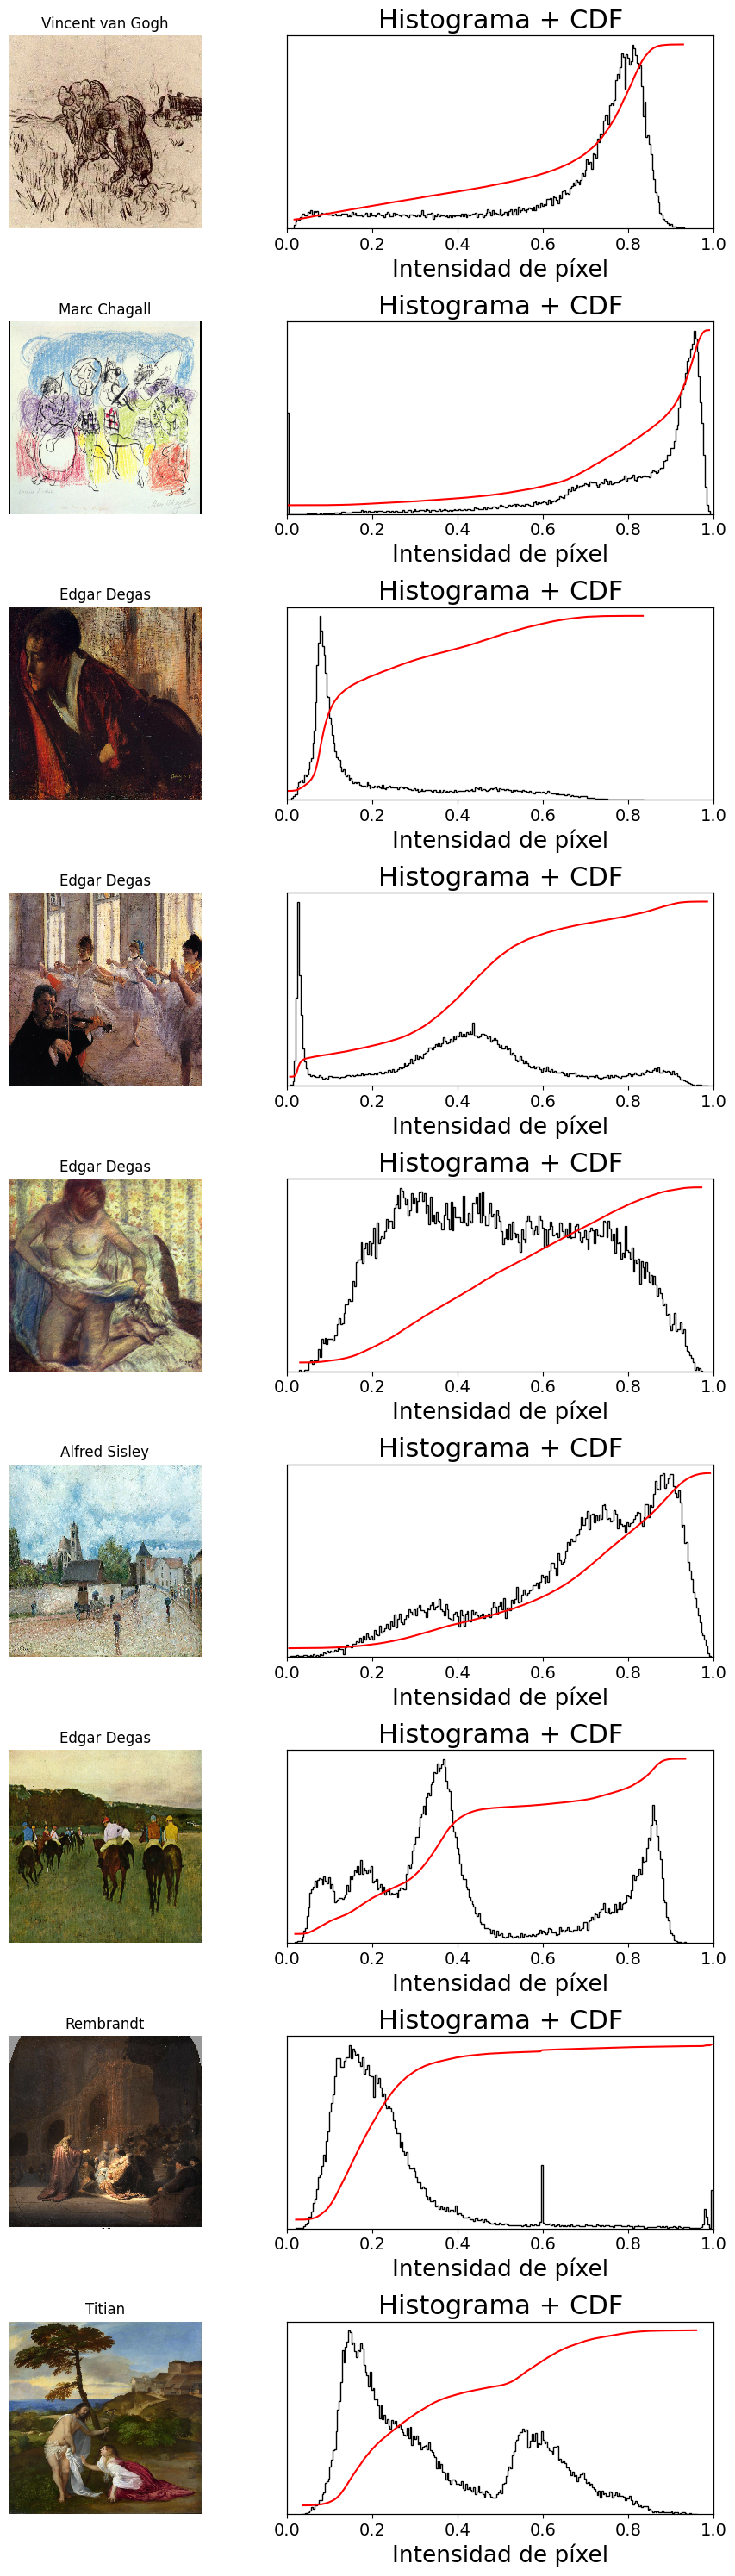

In [54]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2gray
from skimage import exposure, img_as_float

# Mostrar 9 imágenes aleatorias del dataset con sus histogramas (2 columnas: imagen + histograma)
fig, axes = plt.subplots(9, 2, figsize=(10, 30))

for idx, (images, labels) in enumerate(train_set.take(1)):
    for i in range(9):
        img = images[i].numpy().astype("uint8")
        gray = rgb2gray(img)
        gray = img_as_float(gray)

        # Imagen
        ax_img = axes[i, 0]
        ax_img.imshow(img)
        author_index = tf.argmax(labels[i]).numpy()
        author = class_names[author_index].split('_')
        title = ' '.join(author)
        ax_img.set_title(title, fontsize=12)
        ax_img.axis("off")

        # Histograma + CDF
        ax_hist = axes[i, 1]
        ax_cdf = ax_hist.twinx()
        ax_hist.hist(gray.ravel(), bins=256, histtype='step', color='black')
        img_cdf, bins = exposure.cumulative_distribution(gray, 256)
        ax_cdf.plot(bins, img_cdf, 'r')
        ax_hist.set_xlim(0, 1)
        ax_hist.set_xlabel("Intensidad de píxel")
        ax_hist.set_title("Histograma + CDF")
        ax_hist.set_yticks([])
        ax_cdf.set_yticks([])

plt.tight_layout()
plt.show()


#### Análisis genérico de histogramas de intensidad (escala de grises)

El uso de histogramas de intensidad y sus distribuciones acumuladas (CDF) permite obtener información cuantitativa sobre la luminosidad y el contraste de las imágenes del conjunto de datos, independientemente del autor o la obra específica.

**Aspectos relevantes que se pueden interpretar con este análisis:**

- **Distribución tonal:** Histogramas centrados indican imágenes equilibradas en luz y sombra; si están desplazados hacia la izquierda o derecha, reflejan obras dominadas por tonos oscuros o claros, respectivamente.

- **Contraste:** Histogramas con picos pronunciados o bien distribuidos a lo largo del eje horizontal sugieren alto contraste (muchas diferencias de brillo entre zonas). En cambio, un histograma concentrado en una franja estrecha indica una imagen más plana en intensidad.

- **Curva acumulativa (CDF):** Una CDF que crece rápidamente al principio indica predominio de zonas oscuras; si crece lentamente hasta el final, predomina la luminosidad.



---
### 2.3. Visualización del histograma por canal RGB

En este bloque se muestran 9 imágenes seleccionadas aleatoriamente del conjunto de entrenamiento junto con sus histogramas de color separados por canal (Rojo, Verde y Azul).

Cada histograma refleja la distribución de intensidades en cada uno de los tres canales de color, permitiendo observar la predominancia de ciertos tonos, el rango dinámico utilizado y posibles diferencias estilísticas entre autores.

Este tipo de análisis complementa el histograma en escala de grises y es especialmente útil para estudiar la paleta cromática y el uso del color en obras pictóricas.

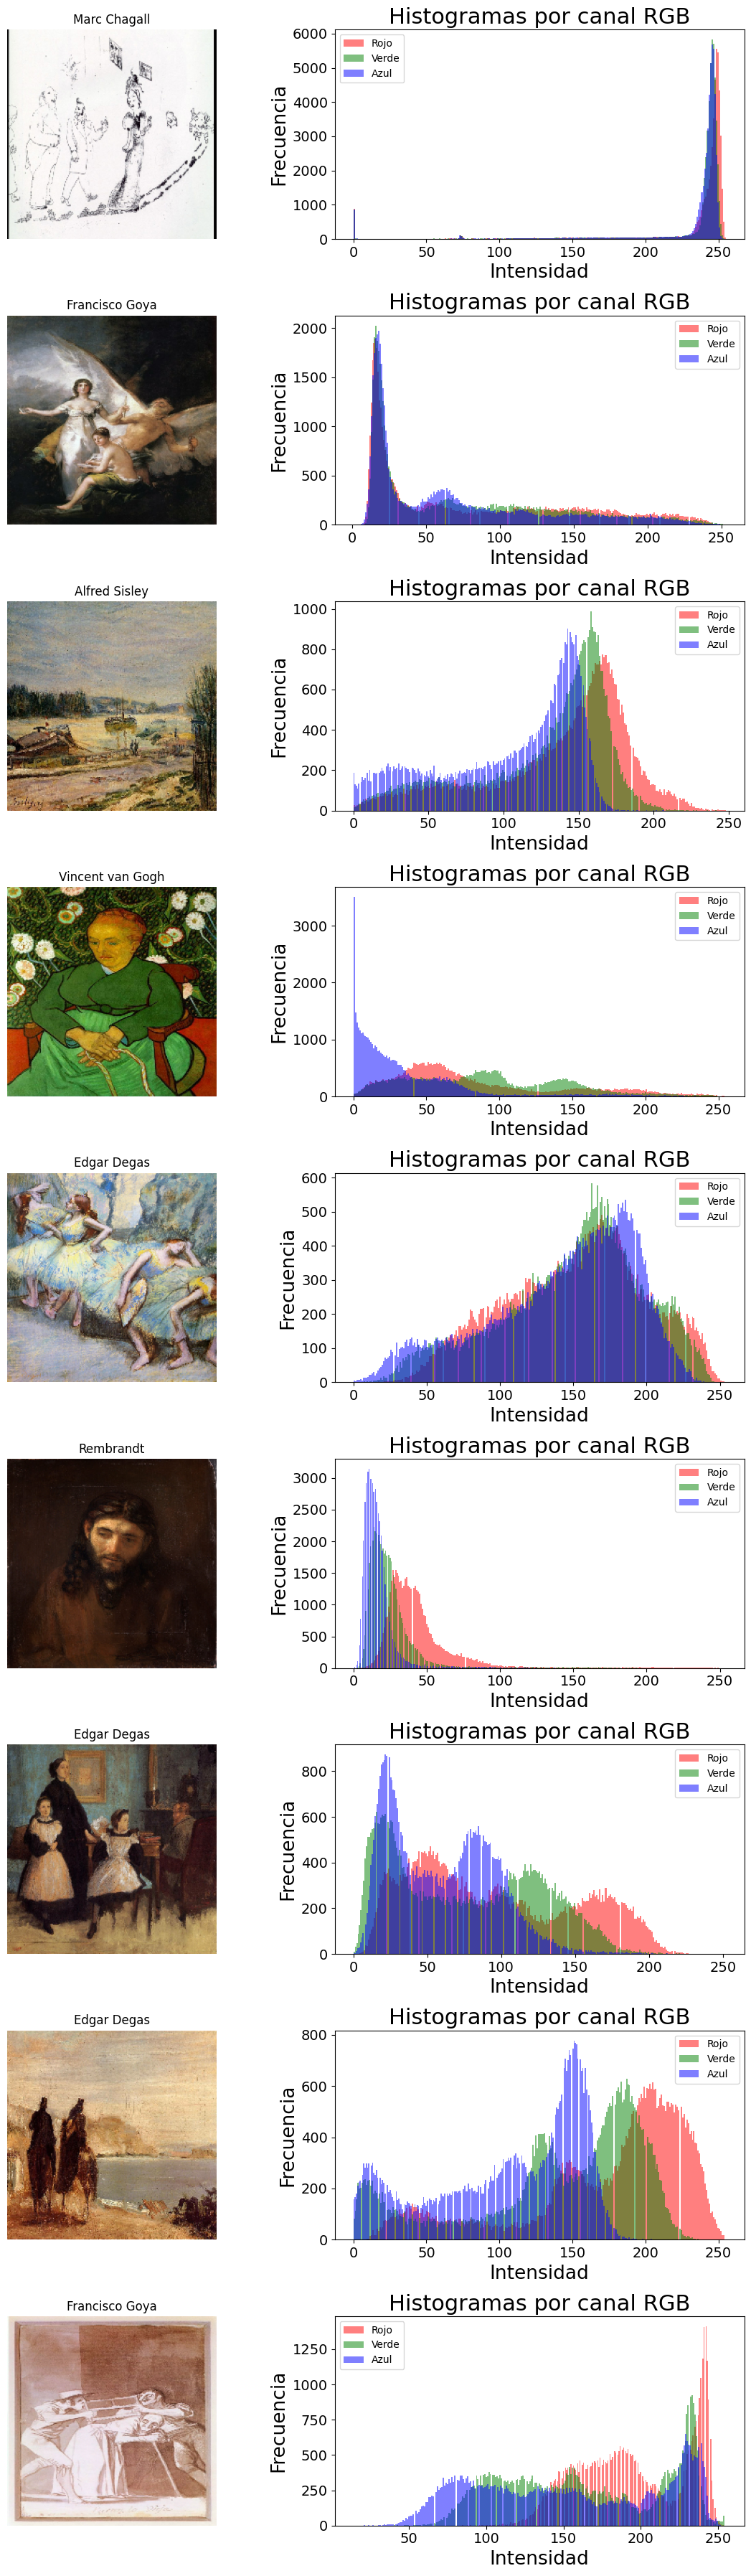

In [56]:
# Mostrar 9 imágenes aleatorias del dataset con sus histogramas RGB
fig, axes = plt.subplots(9, 2, figsize=(12, 36))

for idx, (images, labels) in enumerate(train_set.take(1)):
    for i in range(9):
        img = images[i].numpy().astype("uint8")
        r, g, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]

        # Imagen
        ax_img = axes[i, 0]
        ax_img.imshow(img)
        author_index = tf.argmax(labels[i]).numpy()
        author = class_names[author_index].split('_')
        title = ' '.join(author)
        ax_img.set_title(title, fontsize=12)
        ax_img.axis("off")

        # Histograma RGB
        ax_hist = axes[i, 1]
        ax_hist.hist(r.ravel(), bins=256, color='red', alpha=0.5, label='Rojo')
        ax_hist.hist(g.ravel(), bins=256, color='green', alpha=0.5, label='Verde')
        ax_hist.hist(b.ravel(), bins=256, color='blue', alpha=0.5, label='Azul')
        ax_hist.set_title("Histogramas por canal RGB")
        ax_hist.set_xlabel("Intensidad")
        ax_hist.set_ylabel("Frecuencia")
        ax_hist.legend()

plt.tight_layout()
plt.show()


#### Análisis general del uso del color en las imágenes

El análisis de histogramas RGB permite observar cómo varía el uso del color en las pinturas del dataset:

- Algunas imágenes presentan picos bien definidos en un canal concreto, lo que indica una fuerte dominancia de ese color (por ejemplo, rojos intensos o azules saturados).
- Otras distribuyen los tres canales de forma equilibrada, lo cual sugiere una paleta más neutra o natural.
- En varios casos, los histogramas muestran cortes abruptos en los extremos (0 o 255), lo que indica uso de sombras profundas o blancos puros.
- También pueden observarse imágenes con una distribución más uniforme en uno o varios canales, reflejando gradaciones suaves y ausencia de contraste fuerte.
